<h1>Hands On: Ensemble Learning and Random Forest.</h1>

Una vez estudiada la modelización por árboles de decisión, en este notebook se estudiarán los modelos de ensemble (Ensemble Learning) y en especial su caso más paradigmático: el Random Forest. Los apartados en los que se estudiarán en este capítulo son los siguientes:

  - Voting classifiers.
  - Bagging y Pasting.
  - Random Patches y Random Subspaces.
  - Random Forest. 
  - Boosting: AdaBoost y Gradient Boosting.
  - Stacking.
  
El objetivo es entender el uso de modelos de ensemble de modelos, cómo estos mejoran la capacidad de predicción, los métodos de bagging, boosting y el algoritmo de Random Forest.

<h3>Imports</h3>

In [49]:
# Imports generales:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error

# Algoritmos:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

# Para esconder los warning:
import warnings
warnings.filterwarnings('ignore')

<h2>Voting Classifiers</h2>

Todos los modelos de Ensemble (uniones de distintos modelos) se basan en la premisa de que un conjunto de electores decidirán, en común, mejor que un único elector ("wisdom of the crowd"). Al conjunto de modelos que se unen se les llama Ensemble. A la técnica Ensemble Learning, y un algoritmo de ensemble es un Ensemble method.

Por ejemplo, si juntas un conjunto de Decision Trees tienes un Random Forest. Lo usual es utilizar estos Ensemble methods al final de un proyecto, una vez ya tienes unos cuantos modelos buenos. Estos Ensemble suelen ganar las competiciones de ML.

El primer ejemplo de Ensemble que vamos a ver son los Voting Classifier. Imagina que tienes n modelos ya enrenados con un porcentaje relativamente alto de accuracy en cada uno (pongamos un 80%). Una forma muy simple y muy directa de hacer Ensemble con ellos es predecir con todos, y dar como correcto aquel valor predicho por un grupo mayor. A esto se les llama modelos de votación (Voting Classifiers).

Estos voting classifier suelen conseguir mejores resultados que el mejor de los modelos del Ensemble. Incluso, si cada classifier interno es un "weak classifier" (es malo, ligeramente mejor que un clasificador random) los resultados son buenos si se ponen los suficientes clasificadores distintos.

Esto se explica con la ley de los números grandes. Por ejemplo, si tienes 1000 clasificadores binarios con un 51% de accuracy, la unión de estos tendrá más de un 75% de accuracy! (Como, por ejemplo, si tiras una moneda trucada a un 51% de posibilidades 1000 veces, la posibilidad de que tengas una mayoría de caras que de cruces es del 75%.

Para que los modelos de Ensemble funcionen correctamente, es importante que los clasificadores sean lo mas independientes posible entre si. Una forma es entrenarlos con algoritmos muy distintos, que aumenta la probabilidad de que los errores que se cometan sean muy distintos entre sí.

Vamos a ver con código como se hace un Voting Classifier:

In [2]:
# Primero entrenamos un dataset Moons:

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fijamos el random seed (en 1994 porque nací en ese año, sin más)

np.random.seed(1994)

# Ahora entrenamos unos cuantos modelos con este dataset:

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()


# El clasificador Voting
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

# Se entrena el voting:

voting_clf.fit(X_train, y_train)

# Vamos a ver el accuracy:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.904


Como se ve, el Voting suele obtener igual o mejor resultado que el mejor de los classifier. 

Si todos los modelos que conforman el Ensemble son capaces de hacer un predict_proba() (es decir, predicen probabilidades de las distintas clases), entonces se puede decir a Sklearn que prediga la clase con mayor probabilidad haciendo un promedio entre todas las predicciones individuales. Esto es llamado "soft voting" (sólo hace falta establecer el parámetro voting='soft').

En el ejemplo puesto hay que cambiar el hiperparámetro de SVC probability=true para que funcione (esto hace que se use un cross-validation en el SVC para sacar las probabilidades, haciendo más lento el entrenamiento pero añadiendo un método predict_proba()). Sería tal que así:

In [3]:
# Se entrenan para el soft voting. Hacemos random_state=42 para alinear los resultados con el Hands On:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) #probability=true para que funcione el soft voting

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

# Y aquí se ven las probabilidades:

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.912


<h2>Bagging y Pasting</h2>

En el anterior punto se utilizaban distintos algoritmos y luego se hacía Ensemble de ellos. Otra aproximación es usar un mismo algoritmo, y entrenar varios modelos del mismo en distintas secciones del training set. Cuando el entrenamiento se hace con replacement esto se llama "bagging" (bootstrap aggregating). Cuando se realiza sin replacement, se llama "pasting".

En otras palabras, el bagging y el pasting permiten al dataset ser mezclado varias veces entre multiples modelos, pero solo bagging permite al dataset ser mezclado varias veces para el mismo predictor.

Una vez todos los modelos han sido entrenados, el Ensemble puede hacer una predicción para una nueva instance simplemente agregando las predicciones de todos los modelos. La función de agregación es, tipicamente, de modo estadístico (o el promedio de la regresión). Cada modelo por separado tiene un bias mayor que si se hubiese entrenado con todo el dataset, pero el conjunto reduce tanto el bias como la varianza. Generalmente, el ensemble tiene un bias similar pero una varianza menor que el modelo simple entrenado con todo el training set.

Bagging y Pasting escalan genial porque pueden hacerse paralelamente en los distintos CPU cores (o diferentes servers). Por este motivo son bastante populares.

Sklearn tiene un API simple para bagging y pasting con la clase BaggingClassifier (o BaggingRegressor para regresión). El hiperparámetro que distingue entre Bagging y Pasting es bootstrap (siendo true para bagging, y false para pasting). El hiperparámetro n_jobs controla el número de cores a utilizar en el entrenamiento (con n_jobs=-1 se le dice que use todos los disponibles). Ejemplo:

In [4]:
# Se entrena un bagging sobre un decision tree
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

# Vamos a entrenar también un decision tree para comparar:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

# Viendo el accuracy
print('Accuracy del decision tree: ' + str(accuracy_score(y_test, y_pred_tree)))
print('Accuracy del Bagging de DT: ' + str(accuracy_score(y_test, y_pred)))

Accuracy del decision tree: 0.856
Accuracy del Bagging de DT: 0.912


Al hacer bagging, algunas instances se mezclan varias veces para cada modelo, mientras que otras no se mezclan. Por ejemplo, si se entrena un modelo con m instances y replacement y valores por defecto, en torno al 63% de los training instances son mezcladas en cada predictor. El 37% restante son las llamadas "out-of-bag" (oob) instances, pero es importante que estas no son las mismas para cada predictor.

Esto se puede utilizar, ya que las oob se pueden usar para evaluar el predictor entrenado sin necesidad de usar un validation test. Esto se hace en Sklearn con el parámetro oob_score=True. Por ejemplo:

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train,y_train)
print('El score sobre oob es: ' + str(bag_clf.oob_score_))
print('La accuracy es: ' + str(accuracy_score(y_test,bag_clf.predict(X_test))))

El score sobre oob es: 0.896
La accuracy es: 0.92


Se parecen, no está mal. Además existe un método oob_decision_function (si el algoritmo base tiene predict_proba()) para ver la probabilidad de cada clase.

<h2>Random Patches y Random Subspaces</h2>

El método BaggingClassifier también permite mezclar las variables a usar. Esto se controla con dos hiperparámetros (max_features y bootstrap_features). Funcionan igual que max_samples y bootstrap, pero para variables en vez de instances.

Esto es útil sobre todo cuando tienes un dataset con muchas variables (como por ejemplo imágenes). Entrenar tanto instances como variables se conoce como Random Patches Method. Entrenar solo variables se llama Random Subspaces Method.

Hacer mezcla de variables aumenta el bias pero reduce la varianza.

<h2>Random Forests</h2>

El Random Forest es un ensemble de Decision Trees, generalmente entrenados en bagging, con max_samples al tamaño del training set. Por eso, en lugar de entrenar un BaggingClassifier y pasar un DecissionTreeClassifier, se puede usar un RandomForestClassifier (que está más optimizado). Ejemplo de código:

In [6]:
# El código de RandomForest sería:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)


# El código equivalente con bagging es:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# Comparando ambos:

np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

En los RF, en cada nodo solo se utiliza un subset aleatorio de las variables consideradas para splitting. Es posible hacer árboles incluso mas aleatorios si se usan random thresholds para cada variable en lugar de buscar la mejor posible. Esto es llamado Extremely Randomized Trees ensemble (o Extra-Trees). Es mucho más rapido de entrenar, pero tiene mas bias (y menos varianza).

La clase de Sklearn para los Extra-Trees es ExtraTreesClassifier. Funciona igual que la de RF. Y, normalmente, la única forma de saber cuál funciona mejor es probar con los dos.

Otro aspecto muy importante de los RF es que permiten medir la importancia de cada variable (feature importance). Sklearn lo mide fijandose en cuanto reducen la impurity los nodos que usan cada variable (más preciso es un weighted average).

Se guarda en un atributo del objeto RandomForestClassifier, feature_importance_. Por ejemplo:

In [7]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


<h2>Boosting</h2>

El Boosting ("hypothesis boosting") es la forma de denominar a cualquier ensemble que combine varios weak learners en un strong learner. La idea general de la mayoria es entrenar los predictors de forma secuencial, cada uno tratando de corregir al anterior. Hay muchos tipos de boosting, pero los mas populares son el AdaBoost (Adaptative Boosting) y el Gradient Boosting.

<h3>AdaBoost</h3>

La técnica usada por AdaBoost es que cada nuevo predictor se enfoque mas en las instances que el predecesor no ajustó correctamente (hizo underfitting).

A la hora de entrenar un AdaBoost, el primer classifier entrena y predice sobre el training set. A la hora de entrenar el segundo, el peso relativo de las instances que se han clasificado mal aumenta, y se entrena y se predice. Este proceso se repite para cada classifier. Un detalle importante aquí es que el proceso no se puede paralelizar, porque cada entrenamiento depende del anterior. Por eso escala peor que bagging o pasting.

Cuando se acaba el entrenamiento, se hace la predicción como en el bagging o el pasting, pero cada predictor tiene 
distintos pesos dependiendo de la accuracy que tenga sobre el training set.

El algoritmo viene determinado por la siguiente expresión:

    r_j = sum(w^(i)) :::con y^(i)_j <> y^(i)::: / sum (w^(i))
    
Donde cada el peso de cada instance w^(i) es inicialmente establecida como 1/m y y^(i)_j es la predicción para la instance i.

El peso estadístico de cada predictor es calculado usando la siguiente expresión:

    alpha_j = nu * log((1-r_j)/r_j)
    
Donde alpha_j es el peso estadístico del predictor j, y nu es el hiperparámetro learning rate (por default es 1).

Cuanto más preciso es un predictor, mayor es su peso estadístico alpha. Las siguientes instances de cada predicción se ven aumentadas con la siguiente expresión:

    w^(i) = w^(i)   si y^(i) = y(i)           //        w^(i) = w^(i) * exp (alpha_j)   si y^(i) <> y(i) 

Y después los pesos se normalizan dividiéndolos entre sum(w^(i)).

El algoritmo termina cuando el número de predictors deseado es alcanzado o cuando se encuentra un predictor perfecto.

Para hacer predicciones, AdaBoost computa las predicciones de cada predictor y las usa con sus pesos alpha_j. La clase predicha es aquella que recibe un mayor número de votos ponderados.

    y^(x) = argmax (sum(alpha_j))

Sklearn usa una versión multiclase del AdaBoost llamada SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function). Con dos clases, SAMME es exactamente igual a AdaBoost. Si los predictors usados pueden estimar probabilidades de clases (es decir, tienen predict_proba()), Sklearn usa SAMME.R (donde la R significa Real), que normalmente funciona mejor porque utiliza las probabilidades en lugar de las predicciones para hacer su propia predicción.

Nota: Si tu AdaBoost hace Overfitting, puedes probar a reducir el número de estimators o a regularizar más fuerte el base.

Viendo un ejemplo de AdaBoost:

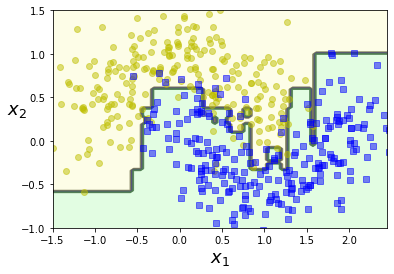

In [12]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

# El decision boundary sería tal que así:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plot_decision_boundary(ada_clf, X, y)

<h3>Gradient Boosting</h3>

Como AdaBoost, el GB entrena los predictors de forma secuencial con cada uno corrigiendo al anterior. Sin embargo, en lugar de cambiar los pesos estadísticos de los instances en cada iteración, GD entrena el nuevo predictor para corregir los errores residuales del anterior. Este algoritmo, por supuesto, también sirve para clasificación y para regresión.

Viendo un ejemplo con Decision Trees (que se le llama comúnmente Gradient Tree Boosting o Gradient Boosted Regression Trees -GBRT-):

In [39]:
# Dataset:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
X_new = np.array([[0.8]])

# Primero se entrena un DecissionTreeRegressor con un training set:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

# Despues se entrena un segundo classifier con los errores residuales:
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

# Se entrena un tercero de la misma forma:
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

# Y se hace ensemble de los tres árboles para predecir sobre un X_new random:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


Por supuesto hay una forma mucho más facil de hacer esto: en Sklearn está implementada la clase GradientBoostingRegressor. Tiene hiperparámetros para definir el tamaño de los árboles (max_depth, min_samples_leaf,...) y el número de árboles (n_estimators). El código de antes se reproduce así:

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

print(gbrt.predict(X_new))

[0.75026781]


El hiperpaámetro learning_rate escala la contribución de cada árbol. Si se establece como un valor bajo (p.e. 0.1) se necesitarán más árboles para un buen fitting, pero las predicciones serán más generales. Esta técnica de regularización se llama shrinkage. 

Para encontrar el número óptimo de árboles se puede usar early stopping. Una forma sencilla de implementar esto es con stagen_predict(), que devuelve un iterator sobre las predicciones echas en cada stage del entrenamiento. El siguiente código entrena con 120 árboles, mide el validation error en cada stage al final del entrenamiento para encontrar el número óptimo de árboles y después entrena otro GBRT con el número óptimo:

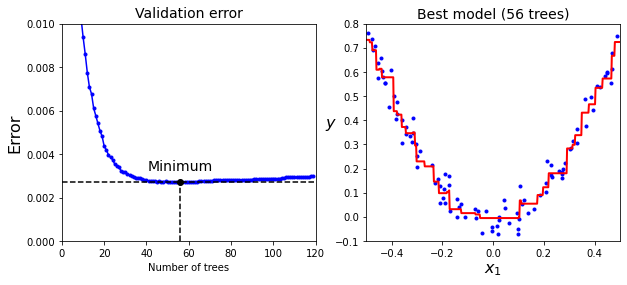

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)

# Gráficamente, el early stopping se ve tal que así:

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

En lugar de entrenar todos los árboles y después ver el mejor, se puede detener el entrenamiento a medias. Para ello se para el entrenamiento cuando el validation error no se mejora en, por ejemplo, 5 iteraciones:

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            
print("Número de estimators: " ,gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

Número de estimators:  61
Minimum validation MSE: 0.002712853325235463


Por último, GradientBoostingRegressor permite un hiperparámetro subsample, que permite controlar la fracción de instances que se usan para entrenar cada arbol. P.e. si subsample=0.25, cada arbol entrena con un 25% del set seleccionado aleatoriamente. Esto intercambia mas bias por menos varianza, y mejora mucho la velocidad de entrenamiento (se le llama Stochastic Gradient Boosting).

Además, con el hiperparámetro loss, se puede entrenar un Gradient Boosting con otra función coste.


En realidad, esto da un poco igual, porque el paquete interesante para hacer Gradient Boosting es XGBoost. Es más rápido, más escalable y da mejores resultados en general. Además, la API de XGBoost es muy similar a la de Sklearn, por lo que se suele usar:

In [51]:
np.random.seed(42)
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

print(xgb_reg.predict(X_new))

[0.74892503]


Además tiene cosas útiles como un early stopping automático:

In [56]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  # Not shown
print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


In [58]:
# Pruebas de tiempo:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) 
%timeit GradientBoostingRegressor().fit(X_train, y_train)

25.2 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.8 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<h2>Stacking</h2>

El último método de ensemble estudiado es Stacking (stacked generalization). Se basa en una idea simple: en lugar de usar funciones triviales para hacer el ensamble (como una votación), se entrena un modelo para hacer esta agregación. El modelo que realiza la agregación se llama "blender" o "meta learner".

Para entrenar el blender se suele hacer un hold-out set o un out-of-fold predicton. Para un hold-out, se separa el training set en 2, se entrena con el primero trozo los modelos y se usa el segundo para entrenar el blender. Para ello se predice con cada modelo sobre el segundo, y se tiene un training set en el que el label es el valor real y las variables son las predicciones de cada modelo.

Se pueden entrenar también varios blender, partiendo el dataset en 3 y utilizando el tercer layer para entrenar un modelo sobre los blender. Esta estructura es similar a las capas de una RN.